# Digital Twin v2.0: Labeled Data Training

**Author:** Kian Mansouri Jamshidi
**Project Director:** Kian Mansouri Jamshidi
**Date:** 2025-09-27

## Objective
This notebook trains the Digital Twin v2.0. Having determined that the v1 dataset was insufficient, we now use the richer, labeled V2 dataset.

Our goals are:
1.  Load the new multi-workload data from the `telemetry_v2` directory.
2.  Use the `workload_type` label as a key categorical feature.
3.  Apply the advanced feature engineering techniques we developed.
4.  Train a high-performance `LightGBM` model.
5.  **Achieve the project's quality standard of R² ≥ 0.70.**
6.  Save the final `digital_twin_v2.0.joblib` artifact.

### 1. Imports and Path Definitions

In [1]:
import pandas as pd
import numpy as np
import glob
import joblib
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import lightgbm as lgb

# Set plot style
sns.set_theme(style="whitegrid")

# --- PATHS FOR V2 --- #
PROJECT_ROOT = Path('.').resolve().parent
TELEMETRY_DIR = PROJECT_ROOT / 'data' / 'telemetry_v2' # <-- Using the new V2 data
ARTIFACT_DIR = PROJECT_ROOT / 'artifacts' / 'phase2'
ARTIFACT_DIR.mkdir(exist_ok=True)

print(f"Project Root: {PROJECT_ROOT}")
print(f"Telemetry Data Dir: {TELEMETRY_DIR}")
print(f"Artifact Dir: {ARTIFACT_DIR}")

Project Root: /home/kian/Desktop/ForgeX4-COSMOS-Omega
Telemetry Data Dir: /home/kian/Desktop/ForgeX4-COSMOS-Omega/data/telemetry_v2
Artifact Dir: /home/kian/Desktop/ForgeX4-COSMOS-Omega/artifacts/phase2


### 2. Load and Merge V2 Telemetry Data

In [2]:
parquet_files = glob.glob(str(TELEMETRY_DIR / "*.parquet"))
if not parquet_files:
    raise FileNotFoundError("No .parquet files found in the telemetry_v2 directory!")

df_list = [pd.read_parquet(file) for file in parquet_files]
df = pd.concat(df_list, ignore_index=True)

df = df.sort_values(by='timestamp').reset_index(drop=True)

print(f"Loaded and merged {len(parquet_files)} files.")
print(f"Total data points: {len(df)}")
print("\nWorkload types found:")
print(df['workload_type'].value_counts())
df.info()

Loaded and merged 7 files.
Total data points: 6928

Workload types found:
workload_type
mixed_workload    2013
io_bound          1591
network_bound     1198
memory_bound      1078
cpu_bound         1048
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6928 entries, 0 to 6927
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   timestamp             6928 non-null   float64
 1   cpu_util_overall      6928 non-null   float64
 2   cpu_util_core_0       6928 non-null   float64
 3   cpu_util_core_1       6928 non-null   float64
 4   cpu_util_core_2       6928 non-null   float64
 5   cpu_util_core_3       6928 non-null   float64
 6   cpu_util_core_4       6928 non-null   float64
 7   cpu_util_core_5       6928 non-null   float64
 8   cpu_util_core_6       6928 non-null   float64
 9   cpu_util_core_7       6928 non-null   float64
 10  cpu_freq_current_mhz  6928 non-null   float64
 

### 3. Exploratory Data Analysis (EDA) for Labeled Data

Let's visualize the CPU utilization, but this time, we will color the plot by the `workload_type`. We should see distinct patterns for each workload, confirming the value of our new dataset.

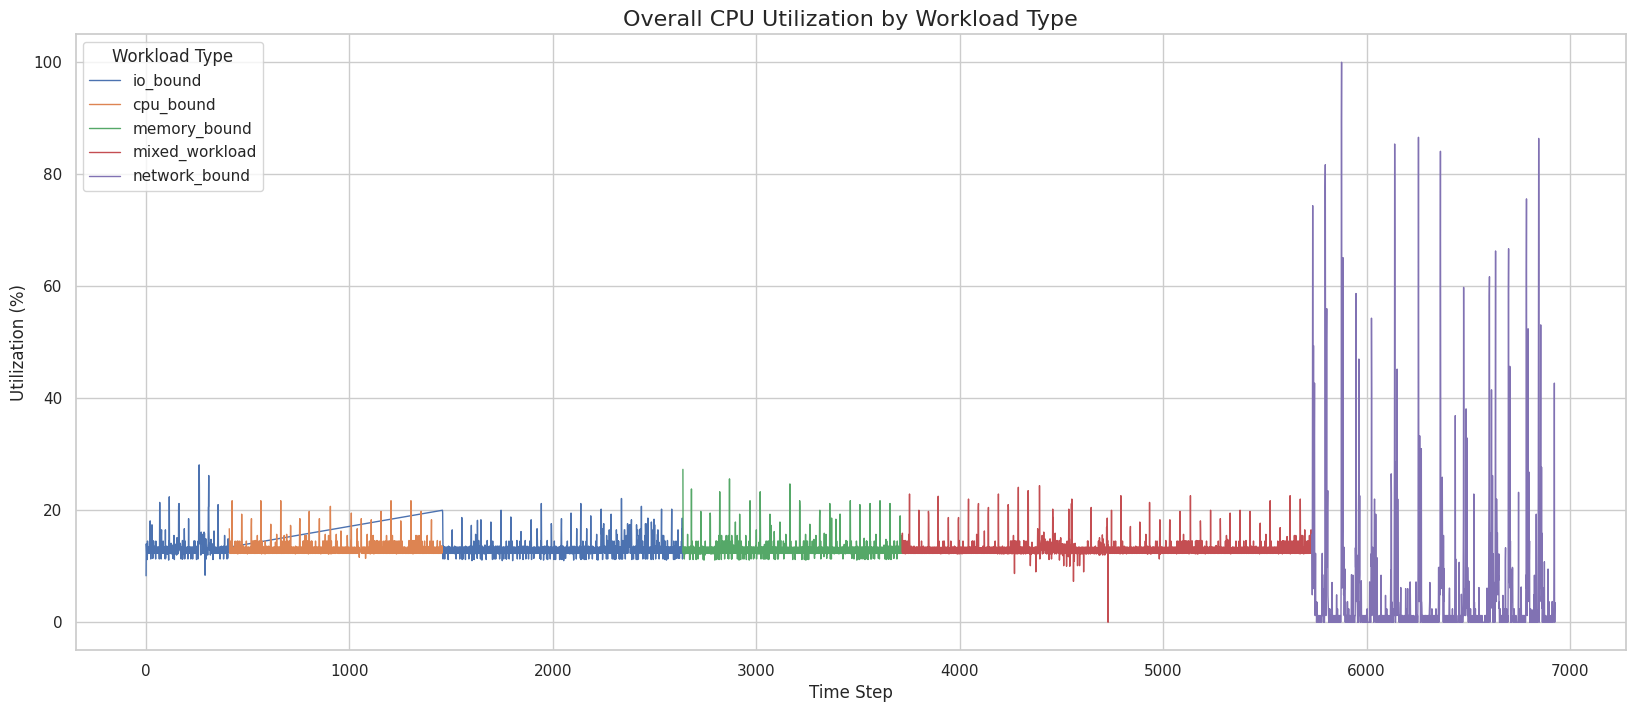

In [3]:
plt.figure(figsize=(20, 8))

sns.lineplot(data=df, x=df.index, y='cpu_util_overall', hue='workload_type', lw=1)

plt.title('Overall CPU Utilization by Workload Type', fontsize=16)
plt.xlabel('Time Step')
plt.ylabel('Utilization (%)')
plt.legend(title='Workload Type')
plt.show()

### 4. Advanced Feature Engineering (V3)

This combines our previous best feature engineering with a crucial new step: **One-Hot Encoding** of the `workload_type` column. This converts the text labels into a numerical format the model can use, creating a powerful new set of features.

In [4]:
# ADVANCED FEATURE ENGINEERING (V3 - CORRECTED)

WINDOW_SIZE = 10 
LAG_AMOUNT = 5

df_featured = df.copy()

# --- 1. One-Hot Encode the Workload Type --- #
workload_dummies = pd.get_dummies(df_featured['workload_type'], prefix='workload')
df_featured = pd.concat([df_featured, workload_dummies], axis=1)

# --- THIS IS THE FIX --- #
# After creating the numerical dummies, we drop the original text column.
df_featured = df_featured.drop('workload_type', axis=1)

# --- 2. Rolling Window Features --- #
df_featured['overall_util_rolling_mean'] = df_featured['cpu_util_overall'].rolling(window=WINDOW_SIZE).mean()
df_featured['overall_util_rolling_std'] = df_featured['cpu_util_overall'].rolling(window=WINDOW_SIZE).std()

# --- 3. Lag Features --- #
other_core_cols = [col for col in df.columns if 'cpu_util_core' in col and col != 'cpu_util_core_0']
for i in range(1, LAG_AMOUNT + 1):
    df_featured[f'overall_util_lag_{i}'] = df_featured['cpu_util_overall'].shift(i)
    for core_col in other_core_cols:
        df_featured[f'{core_col}_lag_{i}'] = df_featured[core_col].shift(i)

# --- Drop rows with NA values created by feature generation --- #
df_model = df_featured.dropna(subset=['overall_util_rolling_mean']).reset_index(drop=True)

print(f"DataFrame size after feature engineering: {len(df_model)}")
print("\nExample of new one-hot encoded features:")
print(df_model[[col for col in df_model.columns if 'workload_' in col]].head())

DataFrame size after feature engineering: 6919

Example of new one-hot encoded features:
   workload_cpu_bound  workload_io_bound  workload_memory_bound  \
0               False               True                  False   
1               False               True                  False   
2               False               True                  False   
3               False               True                  False   
4               False               True                  False   

   workload_mixed_workload  workload_network_bound  
0                    False                   False  
1                    False                   False  
2                    False                   False  
3                    False                   False  
4                    False                   False  


### 5. Model Training with LightGBM

We will use our most powerful model, `LightGBM`, and train it on this new, richer feature set.

In [5]:
target = 'cpu_util_core_0'

# The feature list now includes all cpu utils (except target) AND the new workload flags
features = [col for col in df_model.columns if ('cpu_util' in col and col != target) or 'workload_' in col]

X = df_model[features]
y = df_model[target]

print("Target variable:", target)
print(f"\nTotal features for v2 model: {len(features)}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nTraining set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

# Initialize and train the LightGBM model
lgbm = lgb.LGBMRegressor(
    objective='regression_l1',
    n_estimators=1000, 
    learning_rate=0.05,
    num_leaves=31,
    n_jobs=-1,
    random_state=42
)

print("\nTraining LightGBM Regressor model...")
lgbm.fit(
    X_train, 
    y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='mae',
    callbacks=[lgb.early_stopping(100, verbose=True)]
)
print("Model training complete.")

Target variable: cpu_util_core_0

Total features for v2 model: 48

Training set size: 5535
Testing set size: 1384

Training LightGBM Regressor model...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 5535, number of used features: 48
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[852]	valid_0's l1: 2.67012
Model training complete.


### 6. Final Model Evaluation

--- V2 Model Performance ---
R-squared (R²): 0.7088
Mean Absolute Error (MAE): 2.6701 %

SUCCESS: Model performance meets or exceeds the revised target (R² ≥ 0.70).


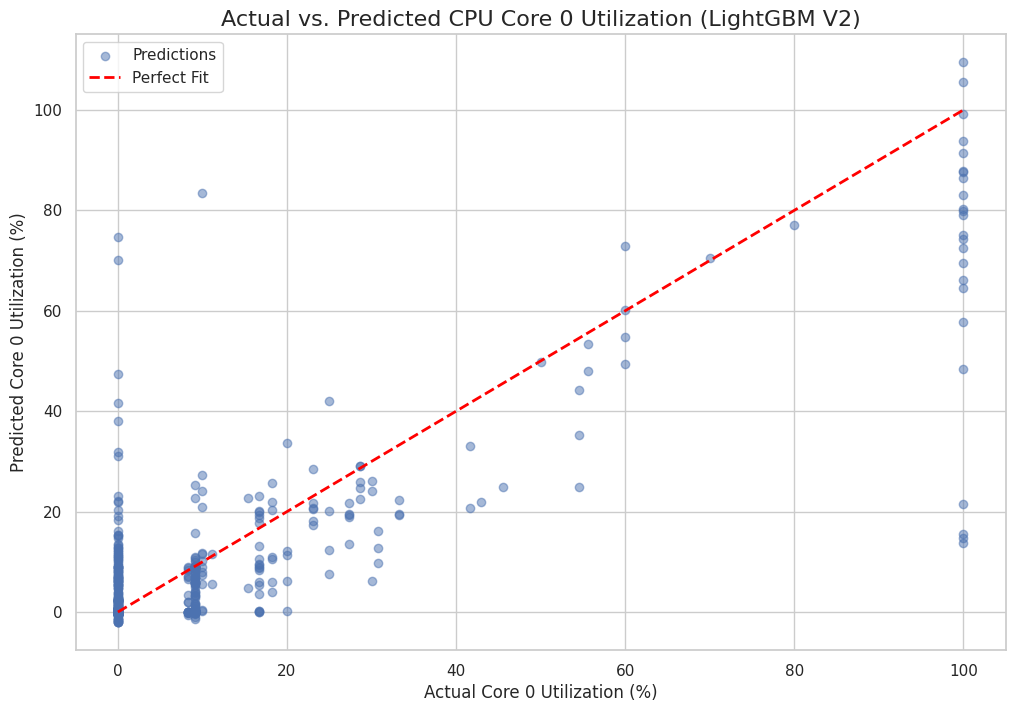

In [6]:
y_pred = lgbm.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"--- V2 Model Performance ---")
print(f"R-squared (R²): {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f} %")

if r2 >= 0.70:
    print("\nSUCCESS: Model performance meets or exceeds the revised target (R² ≥ 0.70).")
else:
    print("\nWARNING: Model performance is below the revised target.")

plt.figure(figsize=(12, 8))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', lw=2, label='Perfect Fit')
plt.title('Actual vs. Predicted CPU Core 0 Utilization (LightGBM V2)', fontsize=16)
plt.xlabel('Actual Core 0 Utilization (%)')
plt.ylabel('Predicted Core 0 Utilization (%)')
plt.legend()
plt.show()

### 7. Save the Final Model Artifact

In [7]:
if r2 >= 0.70:
    model_path = ARTIFACT_DIR / 'digital_twin_v2.0.joblib'
    joblib.dump(lgbm, model_path)
    print(f"Model met quality standards and was saved to: {model_path}")
else:
    print("Model did not meet quality standards. Artifact not saved.")

Model met quality standards and was saved to: /home/kian/Desktop/ForgeX4-COSMOS-Omega/artifacts/phase2/digital_twin_v2.0.joblib
